In [1]:
import numpy as np
import os
os.chdir("C:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH")
import pandas as pd
from stk_search import Database_utils
import importlib
importlib.reload(Database_utils)
#%% 
# Load the searched space
df_path = 'data/output/Full_datatset/df_total_new2023_08_20.csv'
df_precursors_path = 'data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl'#'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)

In [2]:
import pandas as pd
from stk_search import Database_utils
import importlib
importlib.reload(Database_utils)
#%% 
# Load the searched space
df_path = 'data/output/Full_datatset/df_total_new2023_08_20.csv'
df_precursors_path = 'data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl'#'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)


C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_search\src\stk_search\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


In [3]:
import numpy as np
slatm_rpr = np.load('data/output/Full_dataset/repr_df_total_new2023_08_20.npy',allow_pickle=True)
slatm_name = np.load('data/output/Full_dataset/names_df_total_new2023_08_20.npy',allow_pickle=True)

In [4]:
#np.isnan(slatm_rpr).any()
import pandas as pd
slatm_rpr_new=slatm_rpr
print(slatm_rpr_new.shape)
slatm_rpr_new = slatm_rpr_new[:, ~(slatm_rpr_new == slatm_rpr_new[0,:]).all(0)]
print(slatm_rpr_new.shape)

(40975, 40221)
(40975, 14719)


In [9]:
df_total['fosc1']

0        0.1243
1        0.1121
2        0.0925
3        0.1829
4        0.0999
          ...  
40970    0.4610
40971    0.0377
40972    2.6017
40973    0.0085
40974    0.0987
Name: fosc1, Length: 40975, dtype: float64

In [10]:
from stk_search import Search_algorithm
from stk_search import Searched_space
from stk_search import Database_utils
import importlib
importlib.reload(Search_algorithm)

# add pca to df_total

# distribute pca_rpr column to each element
PCA_components=14719
def prepare_search_sapce_data_slatm(SP):
    df_new = pd.concat([df_total, pd.DataFrame(slatm_rpr_new)], axis=1)
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_new)
    searched_space_df=searched_space_df[searched_space_df['target']>-7]
    searched_space_df_sample = searched_space_df.sample(100)
    fitness_acquired_sample = searched_space_df_sample['target'].values
    fitness_acquired = searched_space_df['fosc1'].values
    searched_space_df=searched_space_df[[x for x in range(PCA_components)]]
    searched_space_df_sample = searched_space_df_sample[[x for x in range(10)]]
    return searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample

KeyError: 0

In [71]:
df_search_space_frag = searched_space_df[[f'InChIKey_{x}' for x in range(6)]]

In [157]:
from stk_search import Search_algorithm
from stk_search import Searched_space
from stk_search import Database_utils
import importlib
importlib.reload(Search_algorithm)

def prepare_search_sapce_data(SP):
    SP.add_TSNE_to_df_precuros()
    print(len(SP.precursor_TSNE_X_2d))
    #SP.features_frag=SP.features_frag.append(df_precursors.columns[29:38])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[1:7])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[17:23])
    SP.features_frag=SP.features_frag.append(df_precursors.columns[:1])
    print(SP.features_frag)
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
    searched_space_df=searched_space_df[searched_space_df['target']>-10]

    searched_space_df_sample = searched_space_df.sample(100)
    fitness_acquired_sample = searched_space_df_sample['target'].values
    fitness_acquired = searched_space_df['target'].values
    col_list = []
    for x in SP.features_frag:
        for i in range(6):
            col_list.append(x+f'_{i}')
    searched_space_df = searched_space_df[col_list]
    numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
    searched_space_df = searched_space_df[numeric_cols]
    searched_space_df_sample=searched_space_df_sample[col_list]
    searched_space_df_sample = searched_space_df_sample[numeric_cols]
    return searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample

Training size torch.Size([375, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0980], dtype=torch.float64), std = tensor([0.9873], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: -0.01
MSE score: 1.04
MAE score: 0.84
R2 score: 0.99
MSE score: 0.01
MAE score: 0.07


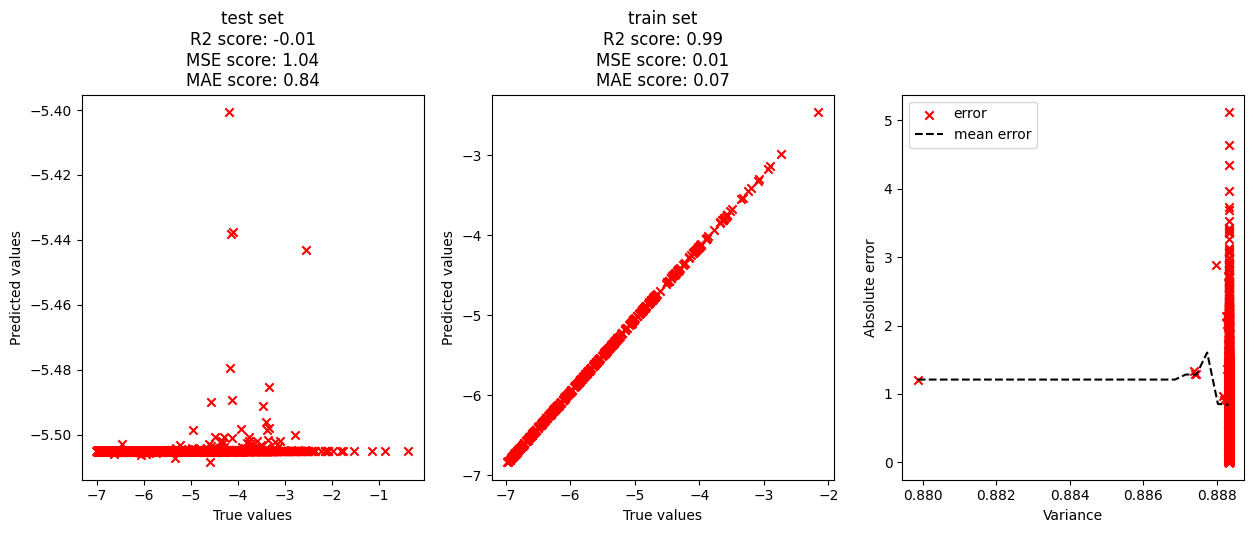

In [155]:
# get the search space using slatm


SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# run BO

searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample = prepare_search_sapce_data_slatm(SP)
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
from botorch.models.gp_regression import SingleTaskGP
BO.kernel = SingleTaskGP
%matplotlib inline
X_train, X_test, y_train , y_test, y_scaler   = BO.get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=0.9)  
print('Training size',X_train.shape)
y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var)


Training size torch.Size([37, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1917], dtype=torch.float64), std = tensor([1.1180], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: -0.04
MSE score: 0.90
MAE score: 0.78
R2 score: 0.00
MSE score: 1.05
MAE score: 0.81


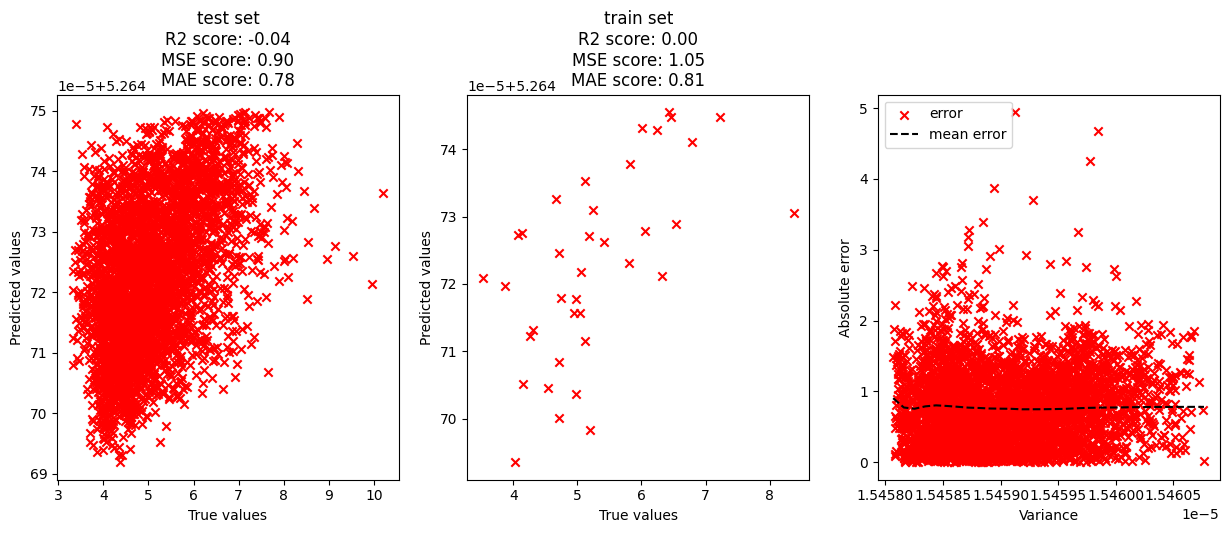

Training size torch.Size([112, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0226], dtype=torch.float64), std = tensor([0.9796], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.30
MSE score: 0.61
MAE score: 0.60
R2 score: 0.57
MSE score: 0.35
MAE score: 0.45


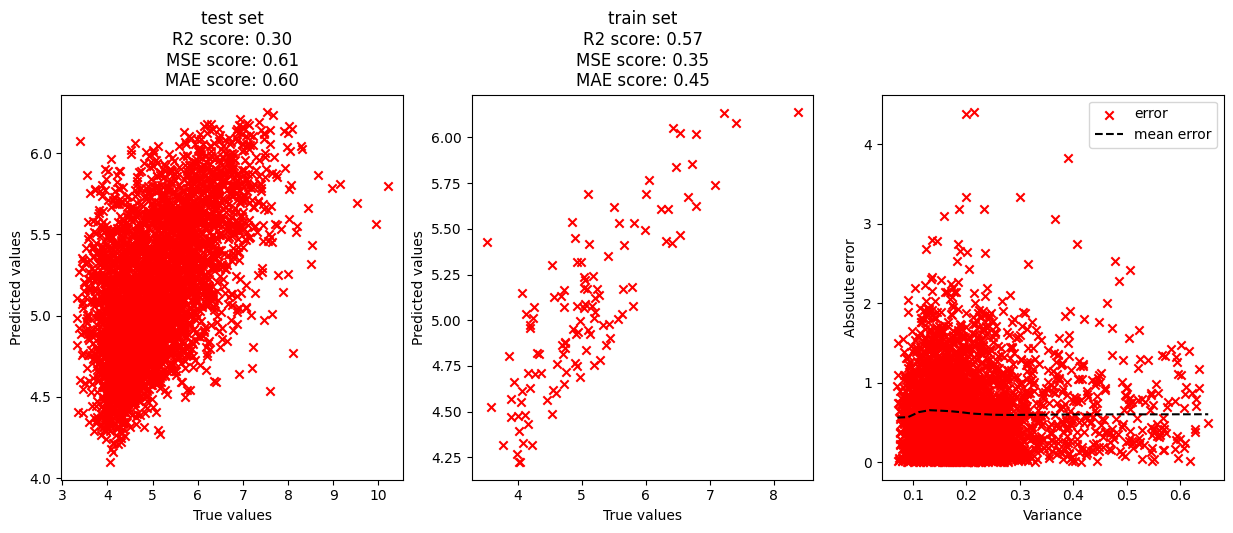

Training size torch.Size([187, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0501], dtype=torch.float64), std = tensor([0.9810], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.37
MSE score: 0.55
MAE score: 0.57
R2 score: 0.65
MSE score: 0.29
MAE score: 0.41


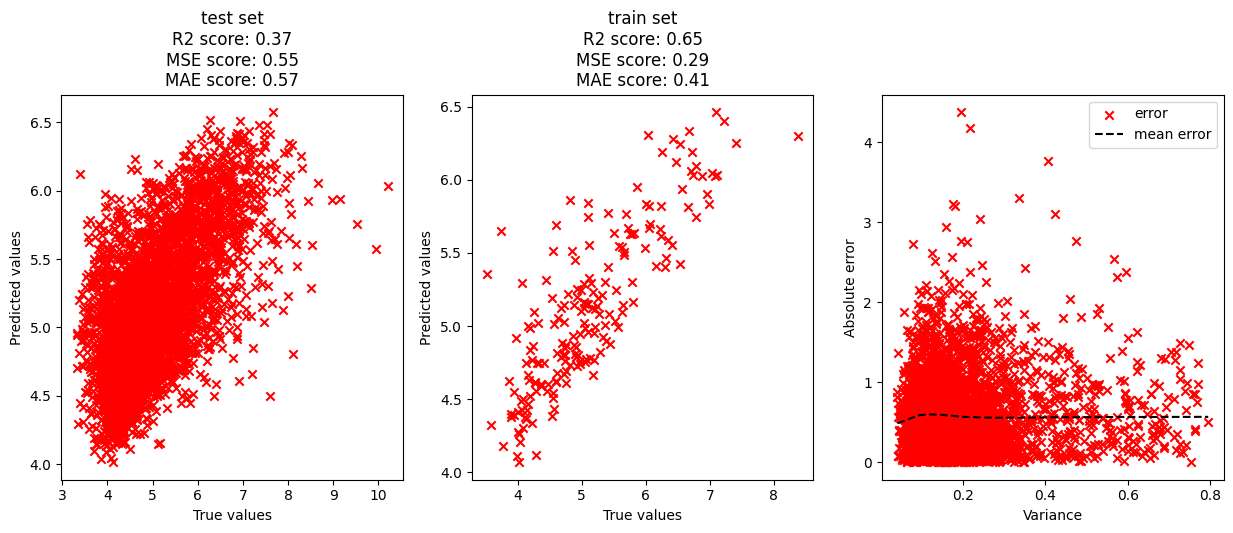

Training size torch.Size([375, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1188], dtype=torch.float64), std = tensor([0.9644], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.49
MSE score: 0.45
MAE score: 0.50
R2 score: 0.74
MSE score: 0.21
MAE score: 0.34


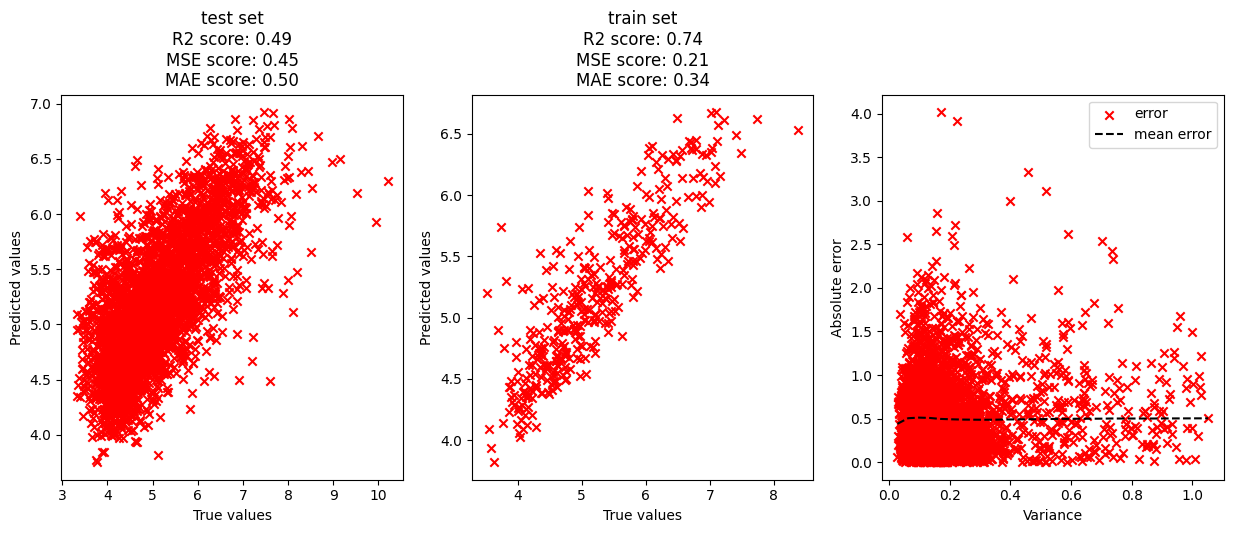

Training size torch.Size([750, 9201])


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0418], dtype=torch.float64), std = tensor([0.9457], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


R2 score: 0.56
MSE score: 0.39
MAE score: 0.46
R2 score: 0.76
MSE score: 0.18
MAE score: 0.31


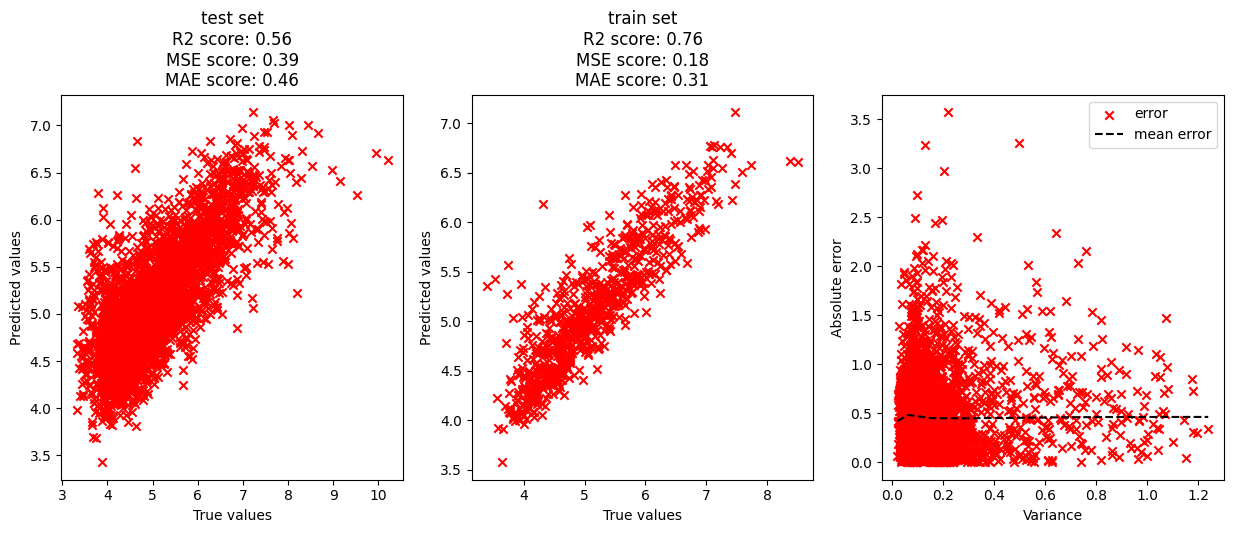

In [14]:
from botorch.models.gp_regression import SingleTaskGP
from stk_search.tanimoto_kernel import TanimotoKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch import kernels 
from stk_search.Search_algorithm import Bayesian_Optimisation
importlib.reload(Bayesian_Optimisation)
class test_kernel(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y, GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())#kernels.RBFKernel())#)
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')

searched_space_df, searched_space_df_sample, fitness_acquired, fitness_acquired_sample = prepare_search_sapce_data_slatm(SP)
BO = Bayesian_Optimisation.Bayesian_Optimisation()
BO.verbose = True
BO.kernel = test_kernel
%matplotlib inline
test_set_size=0.9
for test_set_size in [0.99,0.97,0.95,0.9,0.8]:
    X_train, X_test, y_train , y_test, y_scaler   = BO.get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=test_set_size)  
    print('Training size',X_train.shape)
    y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
    fig_name='Fosc1_trainsize_'+str(X_train.shape[0])+'_testSi_'+str(X_test.shape[0])+'_kernel_'+'tanimoto'+'.png'
    BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var,save_plot=True,plot_name=fig_name)


In [28]:
from torchmetrics.functional import accuracy
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
import torch
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(25638, 100), nn.ReLU(), nn.Linear(100, 14719))

    def forward(self, x):
        return self.l1(x)
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        loss = self._get_preds_loss_accuracy(batch)

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        loss = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        return loss
    
    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        #x_hat = self.decoder(z)
        loss = F.mse_loss(z, y) # F.mse_loss(x_hat, x) #
        return loss
checkpoint = torch.load(r'C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_search\lightning_logs\f3t61f1q\checkpoints\epoch=99-step=41000.ckpt',map_location=torch.device('cpu'))
model = LitAutoEncoder(Encoder())
model.load_state_dict(checkpoint["state_dict"])
model.eval()

LitAutoEncoder(
  (encoder): Encoder(
    (l1): Sequential(
      (0): Linear(in_features=25638, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=14719, bias=True)
    )
  )
)

In [70]:

from stk_search.Search_algorithm import Bayesian_Optimisation
from stk_search.Search_algorithm import Representation_slatm

from stk_search import Searched_space
importlib.reload(Bayesian_Optimisation)
importlib.reload(Representation_slatm)

import torch
import numpy as np
#load search space
SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# get initial elements


searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
searched_space_df= searched_space_df.sample(100)
# reindex the df
searched_space_df.index = range(len(searched_space_df))
df_search_space_frag = searched_space_df[[f'InChIKey_{x}' for x in range(6)]]
fitness_acquired = searched_space_df['target'].values



In [151]:
def suggest_element(BO,df_search_space_frag,fitness_acquired,SP,benchmark=True,df_total:pd.DataFrame=None):
    df_search = df_search_space_frag.copy()

    X_rpr=BO.Representation.generate_repr(df_search.values)
    X_rpr = X_rpr.double()
    y_explored_BO_norm = torch.tensor(fitness_acquired, dtype=torch.float64) 
    y_explored_BO_norm = (y_explored_BO_norm - y_explored_BO_norm.mean(axis=0)) / (
                y_explored_BO_norm.std(axis=0))
    y_explored_BO_norm = y_explored_BO_norm.reshape(-1, 1)
    BO.train_model(X_rpr, y_explored_BO_norm)
    
    def mutate_element(element):
        elements = []
        for i in range(6):
            for frag in df_precursors.InChIKey:
                element_new = element.copy()
                element_new[i] = frag
                elements.append(element_new)
        return elements
    best_element_arg = fitness_acquired.argsort()[-3:][::-1]
    elements= []
    for element in df_search.loc[best_element_arg].values:
        if len(elements) == 0:
            elements = mutate_element(element)
        else:
            elements = np.append(elements,mutate_element(element),axis=0)

    elements = np.append(elements,df_search.values,axis=0)
    df_elements = pd.DataFrame(elements,columns=[f'InChIKey_{x}' for x in range(6)])
    df_elements = SP.check_df_for_element_from_SP(df_to_check=df_elements)
    if benchmark:
        #take only element in df_total
        df_elements = df_elements.merge(
                        df_total,
                        on=[f"InChIKey_{i}" for i in range(6)],
                        how="left",
                    )
        df_elements.dropna(subset='target',inplace=True)
        df_elements = df_elements[[f"InChIKey_{i}" for i in range(6)]]
        print(df_elements.shape)
    X_unsqueezed = BO.Representation.generate_repr(df_elements.values)
    X_unsqueezed = X_unsqueezed.double()
    X_unsqueezed = X_unsqueezed.reshape(
                -1, 1, X_unsqueezed.shape[1]
            ) 
    acquisition_values = BO.get_acquisition_values(
            BO.model,
            best_f=y_explored_BO_norm.max().item(),
            X_unsqueezed=X_unsqueezed,
        )
        # select element to acquire with maximal aquisition value, which is not in the acquired set already
    ids_sorted_by_aquisition = acquisition_values.argsort(descending=True)
    def add_element(df,element):
        if ~(df==element).all(1).any():
            df.loc[len(df)]=element
            return True
        return False
    print(df_search.shape)
    for id in ids_sorted_by_aquisition:

                if add_element(df_search,df_elements.values[id.item()]):
                    print(id.item())
                    break
                    #index = id.item()
                    #return df_search_space_frag
    print(df_search.shape)
    return len(df_search)-1,df_search

In [2]:
from stk_search.Objective_function import Look_up_table
from stk_search.Search_algorithm import Bayesian_Optimisation
from stk_search.Search_algorithm import Representation_slatm
import numpy as np
import os
os.chdir("C:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH")
import pandas as pd
from stk_search import Database_utils
from stk_search import Searched_space

#%% 
# Load the searched space
df_path = 'data/output/Full_datatset/df_total_new2023_08_20.csv'
df_precursors_path = 'data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl'#'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)



SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# get initial elements

BO = Bayesian_Optimisation.Bayesian_Optimisation()
BO.Representation = Representation_slatm.Representation_slatm()

searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
searched_space_df= searched_space_df.sample(100)
# reindex the df
searched_space_df.index = range(len(searched_space_df))
df_search_space_frag = searched_space_df[[f'InChIKey_{x}' for x in range(6)]]
fitness_acquired = searched_space_df['target'].values

id,df_search_space_frag_new =BO.suggest_element(df_search_space_frag,fitness_acquired,SP,benchmark=True,df_total=df_total)
lookup=Look_up_table(df_total,6)

print(lookup.evaluate_element(df_search_space_frag_new.loc[[id],:])[0])
fitness_acquired = np.append(fitness_acquired,lookup.evaluate_element(df_search_space_frag_new.loc[[id],:])[0])
for x in range(60):
    id,df_search_space_frag_new =BO.suggest_element(df_search_space_frag_new,fitness_acquired,SP,benchmark=True,df_total=df_total)
    print(lookup.evaluate_element(df_search_space_frag_new.loc[[id],:])[0])
    if len(df_search_space_frag_new)==len(fitness_acquired):
        break
    else:
        fitness_acquired = np.append(fitness_acquired,lookup.evaluate_element(df_search_space_frag_new.loc[[id],:])[0])

C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_search\src\stk_search\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(144, 6)
(100, 6)
43
(101, 6)
0   -5.2526
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(140, 6)
(101, 6)
36
(102, 6)
0   -6.7546
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(141, 6)
(102, 6)
28
(103, 6)
0   -5.2298
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(145, 6)
(103, 6)
16
(104, 6)
0   -3.9717
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(153, 6)
(104, 6)
22
(105, 6)
0   -7.4066
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(154, 6)
(105, 6)
28
(106, 6)
0   -4.9194
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(163, 6)
(106, 6)
39
(107, 6)
0   -6.0074
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(164, 6)
(107, 6)
29
(108, 6)
0   -9.9477
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(165, 6)
(108, 6)
40
(109, 6)
0   -4.6156
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(162, 6)
(109, 6)
44
(110, 6)
0   -10.6462
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(163, 6)
(110, 6)
46
(111, 6)
0   -5.2743
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(164, 6)
(111, 6)
8
(112, 6)
0   -2.0793
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(166, 6)
(112, 6)
0
(113, 6)
0   -3.9894
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(167, 6)
(113, 6)
27
(114, 6)
0   -3.927
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(180, 6)
(114, 6)
42
(115, 6)
0   -5.1064
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(181, 6)
(115, 6)
50
(116, 6)
0   -5.3232
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(182, 6)
(116, 6)
41
(117, 6)
0   -9.096
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(183, 6)
(117, 6)
47
(118, 6)
0   -7.8108
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(184, 6)
(118, 6)
14
(119, 6)
0   -3.5564
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(183, 6)
(119, 6)
40
(120, 6)
0   -2.9612
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(173, 6)
(120, 6)
27
(121, 6)
0   -3.3688
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(174, 6)
(121, 6)
19
(122, 6)
0   -8.3072
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(175, 6)
(122, 6)
13
(123, 6)
0   -3.3173
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(176, 6)
(123, 6)
51
(124, 6)
0   -5.5272
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(177, 6)
(124, 6)
21
(125, 6)
0   -4.6473
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(178, 6)
(125, 6)
28
(126, 6)
0   -3.1787
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(183, 6)
(126, 6)
46
(127, 6)
0   -2.2389
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(176, 6)
(127, 6)
26
(128, 6)
0   -4.8692
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(177, 6)
(128, 6)
18
(129, 6)
0   -3.2921
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(178, 6)
(129, 6)
30
(130, 6)
0   -4.1437
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(179, 6)
(130, 6)
7
(131, 6)
0   -3.7888
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(180, 6)
(131, 6)
32
(132, 6)
0   -3.7771
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(181, 6)
(132, 6)
28
(133, 6)
0   -8.0381
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(182, 6)
(133, 6)
17
(134, 6)
0   -3.5112
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(183, 6)
(134, 6)
20
(135, 6)
0   -5.093
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(184, 6)
(135, 6)
34
(136, 6)
0   -8.5418
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(185, 6)
(136, 6)
23
(137, 6)
0   -5.5095
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(186, 6)
(137, 6)
40
(138, 6)
0   -8.2625
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(187, 6)
(138, 6)
46
(139, 6)
0   -3.8034
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(188, 6)
(139, 6)
12
(140, 6)
0   -3.4862
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(189, 6)
(140, 6)
6
(141, 6)
0   -2.1442
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(194, 6)
(141, 6)
35
(142, 6)
0   -3.2192
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(195, 6)
(142, 6)
19
(143, 6)
0   -6.5417
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(196, 6)
(143, 6)
34
(144, 6)
0   -4.0276
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(197, 6)
(144, 6)
24
(145, 6)
0   -6.1314
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(198, 6)
(145, 6)
33
(146, 6)
0   -2.5708
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(199, 6)
(146, 6)
28
(147, 6)
0   -5.744
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(200, 6)
(147, 6)
37
(148, 6)
0   -3.045
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(201, 6)
(148, 6)
16
(149, 6)
0   -3.8156
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(202, 6)
(149, 6)
22
(150, 6)
0   -6.069
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(203, 6)
(150, 6)
32
(151, 6)
0   -5.0098
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(204, 6)
(151, 6)
18
(152, 6)
0   -4.917
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(205, 6)
(152, 6)
40
(153, 6)
0   -7.7215
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(206, 6)
(153, 6)
31
(154, 6)
0   -4.9143
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(207, 6)
(154, 6)
21
(155, 6)
0   -7.1666
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(208, 6)
(155, 6)
11
(156, 6)
0   -4.6246
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(209, 6)
(156, 6)
9
(157, 6)
0   -5.4431
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


(210, 6)
(157, 6)
2
(158, 6)
0   -5.0618
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not

(211, 6)
(158, 6)
30
(159, 6)
0   -11.4899
Name: target, dtype: float64


c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\ma11115\AppData\Local\miniconda3\envs\STKSearch\lib\site-packages\botorch\fit.py:171: RuntimeWarning: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.
  warn(str(err), RuntimeWarning)


(212, 6)
(159, 6)
(159, 6)
0   -11.4899
Name: target, dtype: float64


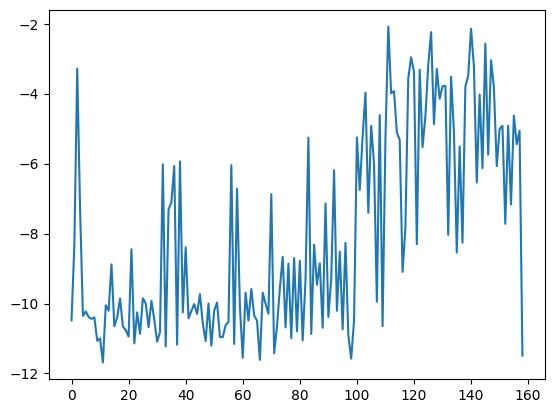

In [3]:
# plot the fitness acquired
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fitness_acquired)
plt.show()

In [4]:
from stk_search import Search_Exp
import importlib
importlib.reload(Search_Exp)
search_space_loc = ""
objective_function = Objective_function.IP_ES1_fosc(oligomer_size=6)
SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
# get initial elements
objective_function=Look_up_table(df_total,6)

BO = Bayesian_Optimisation.Bayesian_Optimisation()
BO.Representation = Representation_slatm.Representation_slatm()
search_algorithm = BO
num_iteration = 5
number_of_iterations = num_iteration
verbose = True
num_elem_initialisation = 50
df_multi = SP.random_generation_df(1000)
S_exp = Search_Exp.Search_exp(
    search_space_loc,
    search_algorithm,
    objective_function,
    number_of_iterations,
    verbose=verbose,
)
S_exp.num_elem_initialisation = num_elem_initialisation



<module 'stk_search.Search_Exp' from 'C:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_search\\src\\stk_search\\Search_Exp.py'>

In [1]:
import random
from stk_search.Objective_function import Look_up_table
from stk_search.Search_algorithm import Bayesian_Optimisation
from stk_search.Search_algorithm import Representation_slatm
import numpy as np
import os
os.chdir("C:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH")
import pandas as pd
from stk_search import Database_utils
from stk_search import Searched_space

#%% 
# Load the searched space
df_path = 'data/output/Full_datatset/df_total_new2023_08_20.csv'
df_precursors_path = 'data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl'#'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)



SP = Searched_space.Searched_Space(number_of_fragments=6,df=df_precursors,features_frag=df_precursors.columns[0:1],generation_type='conditional')
print(random.sample(SP.list_fragment[0],3))
print(SP.number_of_fragments)
print(int(num_element**(1/len(set(self.syntax)))))
def random_generation_df(self,num_element):
    id_list_not_to_merge = []
    max_fragment = int(num_element**(1/len(set(self.syntax))))
    df_list = [None] * self.number_of_fragments
    for i in set(self.syntax):

        if i == 0:
            df_list[i]=self.df_precursors.iloc[list(random.sample(self.list_fragment[0], max_fragment))][
                    self.features_frag
                ]
            df_multi = df_list[i]
            
        else:
            df_list[i]=self.df_precursors.iloc[list(random.sample(self.list_fragment[i], max_fragment))][
                    self.features_frag]
            df_multi = df_multi.merge(df_list[i],
                how="cross",
                suffixes=("", "_" + str(i)),
            )
        id_list_not_to_merge.append(i)
    df_multi = df_multi.rename(
        columns={
            c: c + "_0"
            for c in df_multi.columns
            if c in self.features_frag
        }
    )
    for pos, id in enumerate(self.syntax):
        if pos in id_list_not_to_merge:
            continue
        else:
            df_multi = df_multi.merge(
                df_list[id],
                left_on=f"InChIKey_{id}",
                right_on="InChIKey",
                suffixes=("", "_" + str(pos)),
            )
            df_multi = df_multi.rename(
                columns={
                    c: c + f"_{pos}"
                    for c in df_multi.columns
                    if c in self.features_frag
                }
            )

    print(f"shape of the dataframe {df_multi.shape}")
    return df_multi
#df_multi = random_generation_df(SP,1000)

C:\Users\ma11115\OneDrive - Imperial College London\github_folder\STK_search\src\stk_search\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


[35, 119, 10]
6


NameError: name 'num_element' is not defined

In [16]:
print(int(1000**(1/len(set(SP.syntax)))))
def random_generation_df(self,num_element):
    id_list_not_to_merge = []
    max_fragment = int(num_element**(1/len(set(self.syntax))))+1
    df_list = [None] * self.number_of_fragments
    for i in set(self.syntax):

        if i == 0:
            df_list[i]=self.df_precursors.iloc[list(random.sample(self.list_fragment[0], max_fragment))][
                    self.features_frag
                ]
            df_multi = df_list[i]
            
        else:
            df_list[i]=self.df_precursors.iloc[list(random.sample(self.list_fragment[i], max_fragment))][
                    self.features_frag]
            df_multi = df_multi.merge(df_list[i],
                how="cross",
                suffixes=("", "_" + str(i)),
            )
        id_list_not_to_merge.append(i)
    df_multi = df_multi.rename(
        columns={
            c: c + "_0"
            for c in df_multi.columns
            if c in self.features_frag
        }
    )
    for pos, id in enumerate(self.syntax):
        if pos in id_list_not_to_merge:
            continue
        else:
            df_multi = df_multi.merge(
                df_list[id],
                left_on=f"InChIKey_{id}",
                right_on="InChIKey",
                suffixes=("", "_" + str(pos)),
            )
            df_multi = df_multi.rename(
                columns={
                    c: c + f"_{pos}"
                    for c in df_multi.columns
                    if c in self.features_frag
                }
            )

    df_multi = df_multi.sample(num_element)
    print(f"shape of the dataframe {df_multi.shape}")

    return df_multi
df_multi = random_generation_df(SP,1000)

3
shape of the dataframe (1000, 6)


In [11]:
(4**6)**(1/6)


3.9999999999999996

In [21]:
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split

PCA_components = 3
pca = PCA(n_components=PCA_components)
pca.fit(slatm_rpr)
pca_rpr = pca.transform(slatm_rpr)
def get_test_train_data_for_BO(
        search_space_df: pd.DataFrame = [],
        fitness_acquired: list = [],
        test_set_size: float = 0.2,
    ):
        def transform_data(X_train, y_train, X_test, y_test):
            """
            Apply feature scaling, dimensionality reduction to the data. Return the standardised and low-dimensional train and
            test sets together with the scaler object for the target values.

            :param X_train: input train data
            :param y_train: train labels
            :param X_test: input test data
            :param y_test: test labels
            :return: X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler
            """
            X_train_scaled = (X_train - X_train.min(axis=0).values) / (
                X_train.max(axis=0).values - X_train.min(axis=0).values+0.01
            )
            X_test_scaled = (X_test - X_test.min(axis=0).values) / (
                X_test.max(axis=0).values - X_test.min(axis=0).values+0.01
            )
            y_scaler = StandardScaler()
            y_train_scaled = y_scaler.fit_transform(y_train)
            y_test_scaled = y_scaler.transform(y_test)

            return (
                X_train_scaled,
                y_train_scaled,
                X_test_scaled,
                y_test_scaled,
                y_scaler,
            )

        X_explored = torch.tensor(
            search_space_df.values, dtype=torch.float64
        )
        # limit the dataframe to only the numeric data
        y_explored = torch.tensor(
            fitness_acquired, dtype=torch.float64
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X_explored, y_explored, test_size=test_set_size, random_state=0
        )

        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        #  We standardise the outputs but leave the inputs unchanged

        X_train, y_train, X_test, y_test, y_scaler = transform_data(
            X_train, y_train, X_test, y_test
        )
        return X_train, X_test, y_train, y_test, y_scaler
for x in range(PCA_components):
    df_precursors['pca'+str(x)] = pca_rpr[:,x]
BO = Search_algorithm.Bayesian_Optimisation()
BO.verbose = True
searched_space_df= df_slatm[['slatm_rpr'+str(x) for x in range(1000)]]
#numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
#searched_space_df = searched_space_df[numeric_cols]
df_slatm['target'] = np.abs(df_slatm['1 Excited state Energy (eV)']-4)+np.abs(df_slatm['1 Excited state Osc']-10)
fitness_acquired=df_slatm['target'].values
X_train, X_test, y_train , y_test, y_scaler   = get_test_train_data_for_BO(searched_space_df,fitness_acquired,test_set_size=0.3)  
print('Training size',X_train.shape)
%matplotlib inline

y_pred, y_var, y_pred_train, y_train, y_test, y_var_train = BO.test_model_prediction(X_train, y_train, X_test, y_test, y_scaler)
BO.plot_prediction(y_pred,y_test,y_pred_train,y_train,y_var)


NameError: name 'PCA' is not defined

In [110]:
numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32']).columns
searched_space_df = searched_space_df[numeric_cols]

In [261]:
searched_space_df= df_slatm[['slatm_rpr'+str(x) for x in range(1000)]]

numeric_cols = searched_space_df.select_dtypes(include=['float64', 'int64','float32',]).columns
numeric_cols

Index([], dtype='object')

In [275]:
df_slatm

InChIKey  slatm_rpr0  slatm_rpr1  slatm_rpr2  \
0    HNRHIGPDSSXEJA-FARCUNLSSA-N         0.0         2.0        70.0   
1    XMPYSHMKPRWIPF-UQCOIBPSSA-N         0.0         4.0        70.0   
2    NGTUECGTXMWUQR-UHFFFAOYSA-N         0.0         6.0        70.0   
3    LPTRCOXHGVILNO-UHFFFAOYSA-N         0.0        10.0        70.0   
4    ULRLMMWHCRPTDR-UHFFFAOYSA-N        32.0        12.0        70.0   
..                           ...         ...         ...         ...   
307  DGNQPUBGEVNPSD-WMZJFQQLSA-N         0.0         6.0        70.0   
308  NDEGJNYUKUSEKE-UHFFFAOYSA-N         0.0         6.0        70.0   
309  GOHMZODPOMNOAD-UHFFFAOYSA-N         0.0         6.0        70.0   
310  BJFIUKSBVAJFOJ-WTKPLQERSA-N         0.0         4.0        70.0   
311  PQZAHLJJGPAGBD-OQFOIZHKSA-N         0.0         3.0        70.0   

     slatm_rpr3  slatm_rpr4  slatm_rpr5  slatm_rpr6  slatm_rpr7  slatm_rpr8  \
0          78.0        14.0         8.0        18.0         0.0         0.0   
1          72.0        14.0         8.0         0.0        16.0         0.0   
2         102.0        14.0         8.0         0.0         0.0         0.0   
3          72.0         0.0         0.0         0.0        16.0         0.0   
4          72.0         0.0         0.0         0.0        32.0         0.0   
..          ...         ...         ...         ...         ...         ...   
307        84.0        14.0        16.0         0.0         0.0         0.0   
308        78.0         0.0         8.0         0.0         0.0         0.0   
309        78.0         0.0        16.0         0.0        48.0         0.0   
310        78.0        14.0         8.0         0.0         0.0         0.0   
311        78.0        14.0         8.0         9.0         0.0         0.0   

     ...    pca291    pca292    pca293    pca294        pca295        pca296  \
0    ... -0.000486 -0.001931 -0.000326 -0.001384  7.069663e-04  1.773507e-03   
1    ... -0.000523 -0.000253  0.001012 -0.000301  9.990483e-04  4.074271e-04   
2    ...  0.000001  0.000001 -0.000001 -0.000006 -6.165659e-07  3.598747e-07   
3    ... -0.002748 -0.003003 -0.004311 -0.002269  9.413809e-04  5.046281e-03   
4    ...  0.003341  0.002856  0.000870  0.000388  6.310424e-04  1.892832e-03   
..   ...       ...       ...       ...       ...           ...           ...   
307  ... -0.001397  0.000176 -0.000293 -0.000884  4.379985e-04 -8.527248e-04   
308  ...  0.005473  0.008349  0.009332 -0.011940 -6.563415e-03  4.390469e-03   
309  ...  0.003896  0.001554 -0.000069  0.000046 -9.971129e-04 -6.041081e-04   
310  ... -0.001842 -0.000803 -0.001734  0.001580 -3.990065e-03  2.540008e-03   
311  ...  0.000117 -0.000001  0.000014 -0.000040  1.361768e-05  3.026289e-06   

           pca297    pca298    pca299  slatm_rpr  
0   -1.872595e-03  0.000736 -0.000646          0  
1   -6.420646e-05 -0.000253  0.000718          0  
2    1.621629e-07 -0.000001 -0.000001          0  
3    5.373665e-03 -0.001231  0.001335          0  
4    7.182336e-05 -0.001610  0.002070          0  
..            ...       ...       ...        ...  
307  6.904078e-04 -0.001188  0.001192          0  
308 -7.121810e-03 -0.000728  0.003484          0  
309  1.217317e-03 -0.000383  0.001530          0  
310 -1.349843e-03  0.001236  0.002771          0  
311  1.522456e-06 -0.000026  0.000028          0  

[312 rows x 11427 columns]

In [272]:
X_train

tensor([[0.0000, 0.4545,    nan, 0.3333, 0.0000, 0.6667, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.4167, 0.6667, 0.3333, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.0909,    nan, 0.3333, 0.0000, 0.6667, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.4545,    nan, 1.0000, 0.6667, 0.3333, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.7273,    nan, 0.7500, 0.3333, 0.6667, 0.0000, 0.0000,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.4167, 0.0000, 0.0000, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.6364,    nan, 0.8333, 0.0000, 0.3333, 0.0000, 1.0000,    nan,
            nan],
        [1.0000, 1.0000,    nan, 0.5833, 0.0000, 0.0000, 0.0000, 0.6667,    nan,
            nan],
        [0.0000, 0.5455,    nan, 0.6667, 0.0000, 0.6667, 0.0000, 1.0000,    nan,
            nan],
        [0.0000, 0.2727,    nan, 0.8333, 0.6667, 0.3333, 0.0000, 0.3333,    nan,
            nan],
        [0

In [214]:
print(slatm_names[0])
print(df_precursors[df_precursors['InChIKey']==slatm_names[0].split('/')[1].replace('.xyz','')]['InChIKey'])
slatm_rpr[0]
for count, name in enumerate(slatm_names):
   InChIKey_slatm = name.split('/')[1].replace('.xyz','')
   df_precursors[df_precursors['InChIKey']==InChIKey_slatm]['slatm_rpr'] =  [slatm_rpr[count]]

cache/HNRHIGPDSSXEJA-FARCUNLSSA-N.xyz
254    HNRHIGPDSSXEJA-FARCUNLSSA-N
Name: InChIKey, dtype: object


C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\3848055705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precursors[df_precursors['InChIKey']==InChIKey_slatm]['slatm_rpr'] =  [slatm_rpr[count]]


In [233]:
import pandas as pd
df_slatm = pd.DataFrame(slatm_names,columns=['InChIKey'])
#df_slatm['slatm_rpr']=slatm_rpr

In [247]:
for x in range(slatm_rpr.shape[1]):
    df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]

C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]
C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_slatm['slatm_rpr'+str(x)]= slatm_rpr[:,x]
C:\Users\ma11115\AppData\Local\Temp\ipykernel_1512\198950341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [250]:
df_slatm['InChIKey']=df_slatm['InChIKey'].apply(lambda x: x.split('/')[1].replace('.xyz',''))

IndexError: list index out of range

In [269]:
df_slatm.

0